# Data Mining I - Should we loan?

## Group

* Daniela Tomás, up202004946
* Diogo Nunes, up202007895
* João Veloso, up202005801

## Problem statement



## Task 1: Data Understanding and Preparation

* Firstly, we import the necessary libraries, packages and methods.

In [176]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
from sklearn.preprocessing import LabelEncoder

* We read the data from the CSV files and check the data using the head(), describe(), and other Pandas commands.

In [205]:
account = pd.read_csv('bank/account.csv', delimiter=";")
card_dev = pd.read_csv('bank/card_dev.csv', delimiter=";")
client = pd.read_csv('bank/client.csv', delimiter=";")
disp = pd.read_csv('bank/disp.csv', delimiter=";")
district = pd.read_csv('bank/district.csv', delimiter=";")
loan_dev = pd.read_csv('bank/loan_dev.csv', delimiter=";")
trans_dev = pd.read_csv('bank/trans_dev.csv', delimiter=";")

C:\Users\35191\AppData\Local\Temp\ipykernel_6112\3453540627.py:7: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  trans_dev = pd.read_csv('bank/trans_dev.csv', delimiter=";")


### Account

In [178]:
print(str(account.shape[0]) + " rows and " + str(account.shape[1]) + " cols")
account.head()

4500 rows and 4 cols


,account_id,district_id,frequency,date
0,576,55,monthly issuance,930101
1,3818,74,monthly issuance,930101
2,704,55,monthly issuance,930101
3,2378,16,monthly issuance,930101
4,2632,24,monthly issuance,930102


In [179]:
account.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   account_id   4500 non-null   int64 
 1   district_id  4500 non-null   int64 
 2   frequency    4500 non-null   object
 3   date         4500 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 140.8+ KB


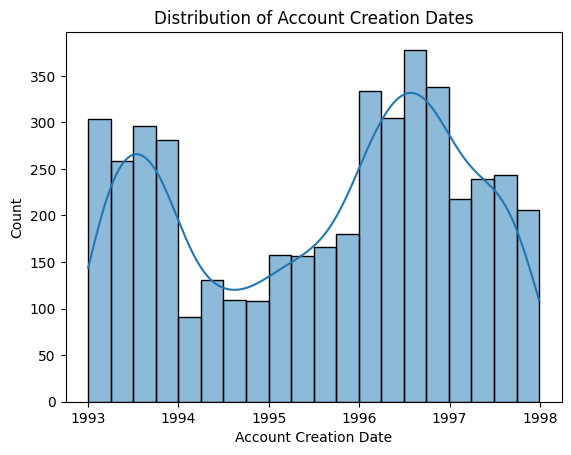

In [180]:
account['date'] = pd.to_datetime(account['date'], format='%y%m%d')
sns.histplot(account['date'], bins=20, kde=True)
plt.xlabel('Account Creation Date')
plt.title('Distribution of Account Creation Dates')
plt.show()

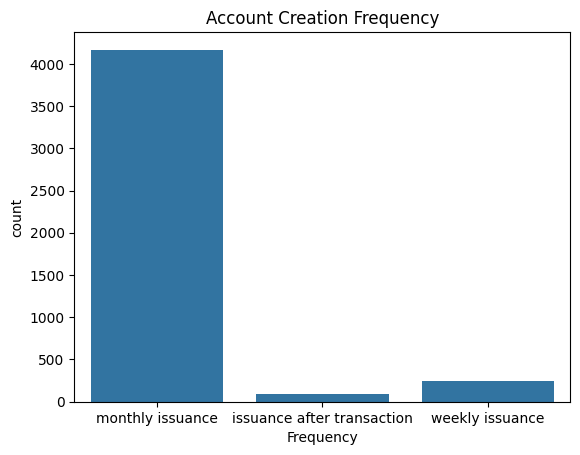

In [181]:
sns.countplot(x='frequency', data=account)
plt.title("Account Creation Frequency")
plt.xlabel("Frequency")
plt.show()

#### Missing Values

In [182]:
print(account.isna().sum())
print()
print("There are " + str((account.isna().sum().sum())) + " NA values")

account_id     0
district_id    0
frequency      0
date           0
dtype: int64

There are 0 NA values


#### Duplicate values

In [183]:
print("Dataset length: " + str(len(account)))
print("Number of duplicates: " + str(account.duplicated().sum()))

Dataset length: 4500
Number of duplicates: 0


### Credit Card

In [184]:
print(str(card_dev.shape[0]) + " rows and " + str(card_dev.shape[1]) + " cols")
card_dev.head()

177 rows and 4 cols


,card_id,disp_id,type,issued
0,1005,9285,classic,931107
1,104,588,classic,940119
2,747,4915,classic,940205
3,70,439,classic,940208
4,577,3687,classic,940215


In [185]:
card_dev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   card_id  177 non-null    int64 
 1   disp_id  177 non-null    int64 
 2   type     177 non-null    object
 3   issued   177 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 5.7+ KB


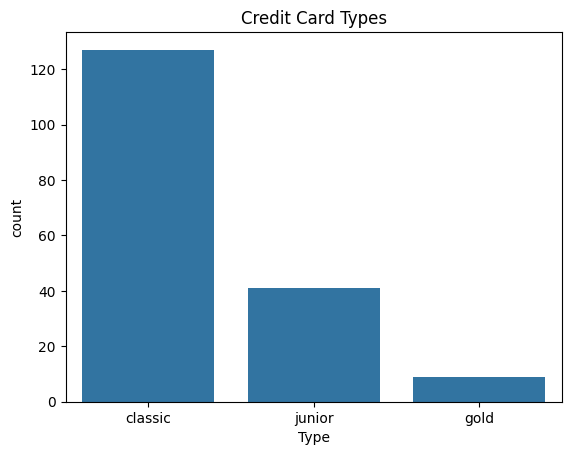

In [186]:
sns.countplot(x='type', data=card_dev)
plt.title("Credit Card Types")
plt.xlabel("Type")
plt.show()

#### Missing Values

In [187]:
print(card_dev.isna().sum())
print()
print("There are " + str((card_dev.isna().sum().sum())) + " NA values")

card_id    0
disp_id    0
type       0
issued     0
dtype: int64

There are 0 NA values


#### Duplicate values

In [188]:
print("Dataset length: " + str(len(card_dev)))
print("Number of duplicates: " + str(card_dev.duplicated().sum()))

Dataset length: 177
Number of duplicates: 0


### Client

In [189]:
print(str(client.shape[0]) + " rows and " + str(client.shape[1]) + " cols")
client.head()

5369 rows and 3 cols


,client_id,birth_number,district_id
0,1,706213,18
1,2,450204,1
2,3,406009,1
3,4,561201,5
4,5,605703,5


In [190]:
client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5369 entries, 0 to 5368
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   client_id     5369 non-null   int64
 1   birth_number  5369 non-null   int64
 2   district_id   5369 non-null   int64
dtypes: int64(3)
memory usage: 126.0 KB


#### Add 'sex' and 'age' columns to the Client dataset

In [191]:
client = pd.read_csv('bank/client.csv', delimiter=";")

client['sex'] = client['birth_number'].apply(lambda x: 'Male' if int(str(x)[2:4]) <= 12 else 'Female')

def calculate_age(row):
    #current_year = datetime.now().year
    if row['sex'] == 'Male':
        birth_date = datetime(int('19' + str(row['birth_number'])[0:2]), int(str(row['birth_number'])[2:4]), int(str(row['birth_number'])[4:6]))
    else:
        birth_date = datetime(int('19' + str(row['birth_number'])[0:2]), int(str(row['birth_number'])[2:4]) - 50, int(str(row['birth_number'])[4:6]))
    age = 1997 - birth_date.year #- ((datetime.now().month, datetime.now().day) < (birth_date.month, birth_date.day))
    return age

client['age'] = client.apply(calculate_age, axis=1)
client.drop('birth_number', axis=1, inplace=True)

print(client[['age', 'sex']])

      age     sex
0      27  Female
1      52    Male
2      57  Female
3      41    Male
4      37  Female
...   ...     ...
5364   52  Female
5365   54    Male
5366   29    Male
5367   35  Female
5368   44  Female

[5369 rows x 2 columns]


In [192]:
m = client['sex'].value_counts()['Male']
f = client['sex'].value_counts()['Female']
print("Number of men:", m)
print("Number of women:", f)

Number of men: 2724
Number of women: 2645


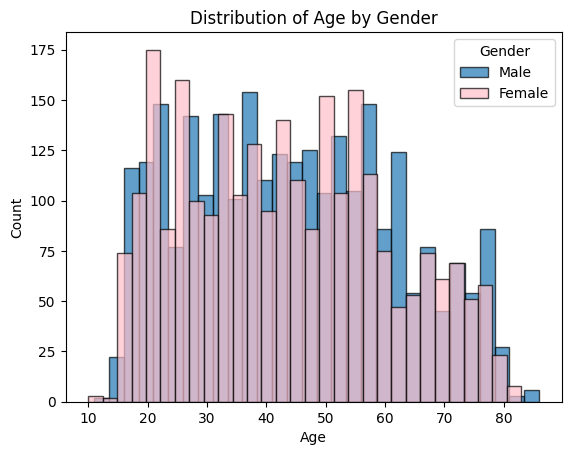

In [193]:
men_birth_years = client[client['sex'] == 'Male']['age']
women_birth_years = client[client['sex'] == 'Female']['age']

plt.hist(men_birth_years, bins=30, alpha=0.7, label='Male', edgecolor='black')
plt.hist(women_birth_years, bins=30, alpha=0.7, label='Female', color='pink', edgecolor='black')

plt.title('Distribution of Age by Gender')
plt.xlabel('Age')
plt.ylabel('Count')

plt.legend(title="Gender")
plt.show()

#### Missing Values

In [194]:
print(client.isna().sum())
print()
print("There are " + str((client.isna().sum().sum())) + " NA values")

client_id      0
district_id    0
sex            0
age            0
dtype: int64

There are 0 NA values


#### Duplicate values

In [195]:
print("Dataset length: " + str(len(client)))
print("Number of duplicates: " + str(client.duplicated().sum()))

Dataset length: 5369
Number of duplicates: 0


### Disposition

In [196]:
print(str(disp.shape[0]) + " rows and " + str(disp.shape[1]) + " cols")
disp.head()

5369 rows and 4 cols


,disp_id,client_id,account_id,type
0,1,1,1,OWNER
1,2,2,2,OWNER
2,3,3,2,DISPONENT
3,4,4,3,OWNER
4,5,5,3,DISPONENT


In [197]:
disp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5369 entries, 0 to 5368
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   disp_id     5369 non-null   int64 
 1   client_id   5369 non-null   int64 
 2   account_id  5369 non-null   int64 
 3   type        5369 non-null   object
dtypes: int64(3), object(1)
memory usage: 167.9+ KB


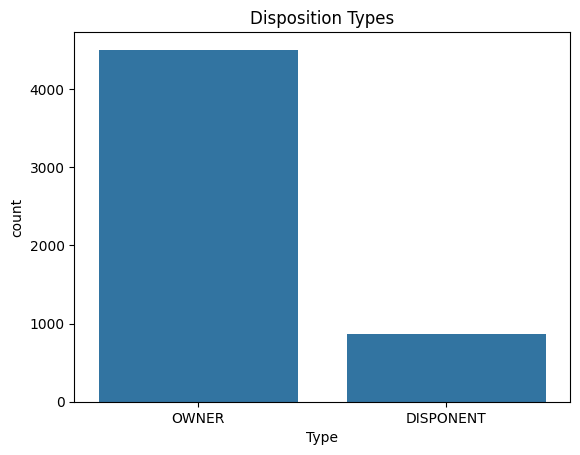

In [198]:
sns.countplot(x='type', data=disp)
plt.title("Disposition Types")
plt.xlabel("Type")
plt.show()

#### Missing Values

In [199]:
print(disp.isna().sum())
print()
print("There are " + str((disp.isna().sum().sum())) + " NA values")

disp_id       0
client_id     0
account_id    0
type          0
dtype: int64

There are 0 NA values


#### Duplicate values

In [200]:
print("Dataset length: " + str(len(disp)))
print("Number of duplicates: " + str(disp.duplicated().sum()))

Dataset length: 5369
Number of duplicates: 0


### Demographic data

In [201]:
print(str(district.shape[0]) + " rows and " + str(district.shape[1]) + " cols")
district.head()

77 rows and 16 cols


,code,name,region,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,unemploymant rate '95,unemploymant rate '96,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes '95,no. of commited crimes '96
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
1,2,Benesov,central Bohemia,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159,2674
2,3,Beroun,central Bohemia,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111,2824,2813
3,4,Kladno,central Bohemia,149893,63,29,6,2,6,67.4,9753,4.64,5.05,109,5244,5892
4,5,Kolin,central Bohemia,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040


In [202]:
district.info()
#print(district.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 16 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   code                                               77 non-null     int64  
 1   name                                               77 non-null     object 
 2   region                                             77 non-null     object 
 3   no. of inhabitants                                 77 non-null     int64  
 4   no. of municipalities with inhabitants < 499       77 non-null     int64  
 5   no. of municipalities with inhabitants 500-1999    77 non-null     int64  
 6   no. of municipalities with inhabitants 2000-9999   77 non-null     int64  
 7   no. of municipalities with inhabitants >10000      77 non-null     int64  
 8   no. of cities                                      77 non-null     int64  
 9   ratio of urb

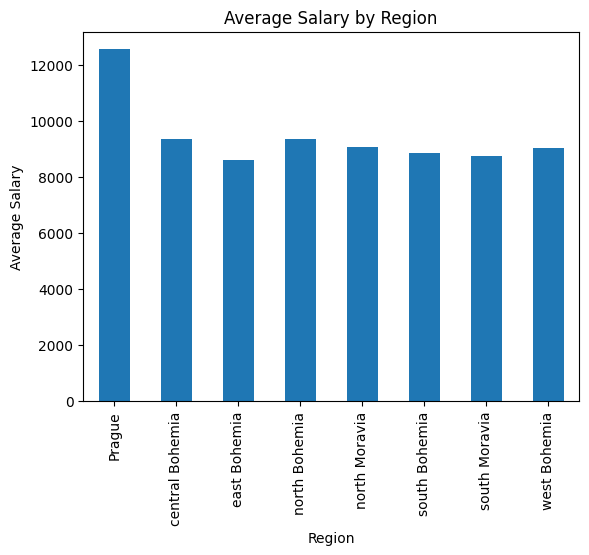

In [207]:
average_salary = district.groupby('region')['average salary '].mean()
average_salary.plot(kind='bar')
plt.title('Average Salary by Region')
plt.xlabel('Region')
plt.ylabel('Average Salary')
plt.show()

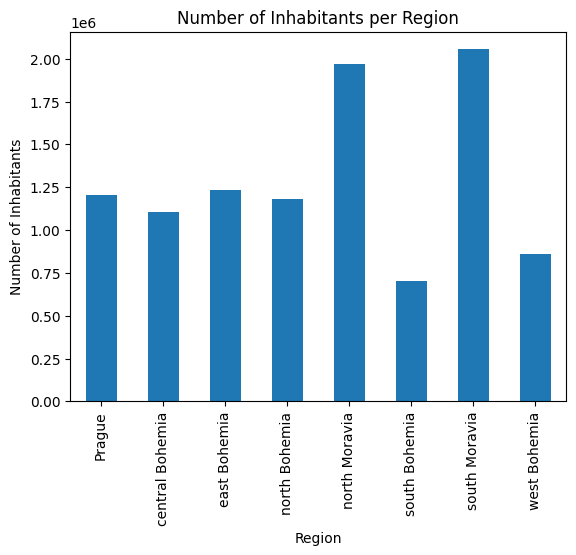

In [ ]:
inhabitants_per_region = district.groupby('region')['no._of_inhabitants'].sum()
inhabitants_per_region.plot(kind='bar')
plt.title('Number of Inhabitants per Region')
plt.xlabel('Region')
plt.ylabel('Number of Inhabitants')
plt.show()


In [ ]:
district.describe()

,code,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,unemploymant rate '96,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes '96
count,77.000000,7.700000e+01,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,39.000000,1.338849e+05,48.623377,24.324675,6.272727,1.727273,6.259740,63.035065,9031.675325,3.787013,116.129870,5030.831169
std,22.371857,1.369135e+05,32.741829,12.780991,4.015222,1.008338,2.435497,16.221727,790.202347,1.908480,16.608773,11270.796786
min,1.000000,4.282100e+04,0.000000,0.000000,0.000000,0.000000,1.000000,33.900000,8110.000000,0.430000,81.000000,888.000000
25%,20.000000,8.585200e+04,22.000000,16.000000,4.000000,1.000000,5.000000,51.900000,8512.000000,2.310000,105.000000,2122.000000
50%,39.000000,1.088710e+05,49.000000,25.000000,6.000000,2.000000,6.000000,59.800000,8814.000000,3.600000,113.000000,3040.000000
75%,58.000000,1.390120e+05,71.000000,32.000000,8.000000,2.000000,8.000000,73.500000,9317.000000,4.790000,126.000000,4595.000000
max,77.000000,1.204953e+06,151.000000,70.000000,20.000000,5.000000,11.000000,100.000000,12541.000000,9.400000,167.000000,99107.000000


#### Missing Values

In [ ]:
print(district.isna().sum())
print()
print("There are " + str((district.isna().sum().sum())) + " NA values")

code_                                                0
name_                                                0
region                                               0
no._of_inhabitants                                   0
no._of_municipalities_with_inhabitants_<_499_        0
no._of_municipalities_with_inhabitants_500-1999      0
no._of_municipalities_with_inhabitants_2000-9999_    0
no._of_municipalities_with_inhabitants_>10000_       0
no._of_cities_                                       0
ratio_of_urban_inhabitants_                          0
average_salary_                                      0
unemploymant_rate_'95_                               0
unemploymant_rate_'96_                               0
no._of_enterpreneurs_per_1000_inhabitants_           0
no._of_commited_crimes_'95_                          0
no._of_commited_crimes_'96_                          0
dtype: int64

There are 0 NA values


#### Duplicate values

In [ ]:
print("Dataset length: " + str(len(district)))
print("Number of duplicates: " + str(district.duplicated().sum()))

Dataset length: 77
Number of duplicates: 0


### Loan

In [ ]:
print(str(loan_dev.shape[0]) + " rows and " + str(loan_dev.shape[1]) + " cols")
loan_dev.head()

328 rows and 7 cols


,loan_id,account_id,date,amount,duration,payments,status
0,5314,1787,930705,96396,12,8033,-1
1,5316,1801,930711,165960,36,4610,1
2,6863,9188,930728,127080,60,2118,1
3,5325,1843,930803,105804,36,2939,1
4,7240,11013,930906,274740,60,4579,1


In [ ]:
loan_dev.info()
#print(loan_dev.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 0 to 327
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   loan_id     328 non-null    int64
 1   account_id  328 non-null    int64
 2   date        328 non-null    int64
 3   amount      328 non-null    int64
 4   duration    328 non-null    int64
 5   payments    328 non-null    int64
 6   status      328 non-null    int64
dtypes: int64(7)
memory usage: 18.1 KB


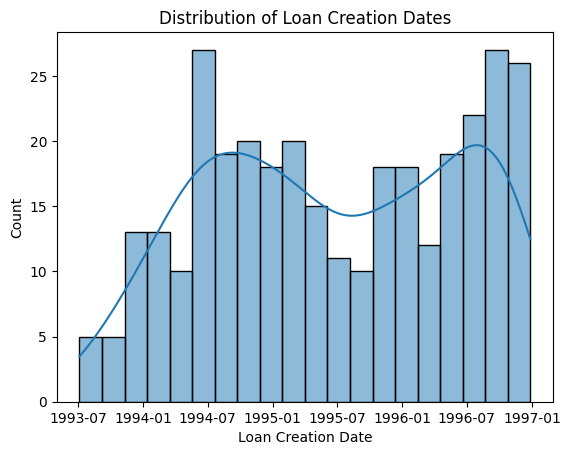

In [ ]:
loan_dev['date'] = pd.to_datetime(loan_dev['date'], format='%y%m%d')
sns.histplot(loan_dev['date'], bins=20, kde=True)
plt.xlabel('Loan Creation Date')
plt.title('Distribution of Loan Creation Dates')
plt.show()

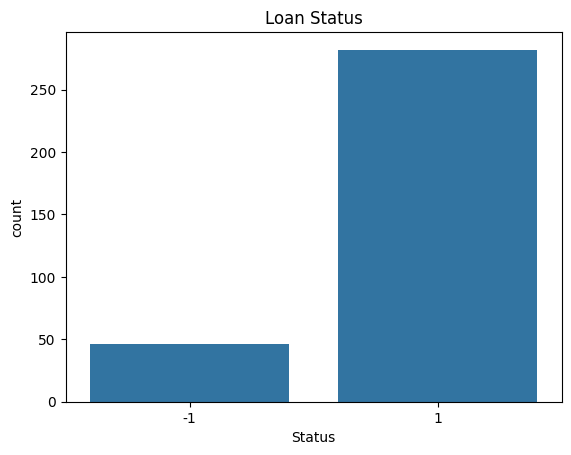

In [ ]:
sns.countplot(x='status', data=loan_dev)
plt.title("Loan Status")
plt.xlabel("Status")
plt.show()

In [ ]:
loan_dev.describe()

,loan_id,account_id,date,amount,duration,payments,status
count,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000
mean,6205.658537,5982.085366,949989.125000,145308.621951,35.853659,4150.932927,0.719512
std,667.985675,3213.262492,9495.504646,105247.318098,16.734752,2193.620989,0.695541
min,4959.000000,2.000000,930705.000000,4980.000000,12.000000,319.000000,-1.000000
25%,5604.250000,3079.000000,940809.250000,68328.000000,24.000000,2368.750000,1.000000
50%,6227.500000,6032.000000,950565.500000,114804.000000,36.000000,3878.500000,1.000000
75%,6737.250000,8564.500000,960525.250000,198600.000000,48.000000,5907.750000,1.000000
max,7308.000000,11362.000000,961227.000000,538500.000000,60.000000,9689.000000,1.000000


#### Missing Values

In [ ]:
print(loan_dev.isna().sum())
print()
print("There are " + str((loan_dev.isna().sum().sum())) + " NA values")

loan_id       0
account_id    0
date          0
amount        0
duration      0
payments      0
status        0
dtype: int64

There are 0 NA values


#### Duplicate values

In [ ]:
print("Dataset length: " + str(len(loan_dev)))
print("Number of duplicates: " + str(loan_dev.duplicated().sum()))

Dataset length: 328
Number of duplicates: 0


### Transaction

In [ ]:
print(str(trans_dev.shape[0]) + " rows and " + str(trans_dev.shape[1]) + " cols")
trans_dev.head()

396685 rows and 10 cols


,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,1548749,5270,930113,credit,credit in cash,800.0,800.0,NaN,NaN,NaN
1,1548750,5270,930114,credit,collection from another bank,44749.0,45549.0,NaN,IJ,80269753.0
2,3393738,11265,930114,credit,credit in cash,1000.0,1000.0,NaN,NaN,NaN
3,3122924,10364,930117,credit,credit in cash,1100.0,1100.0,NaN,NaN,NaN
4,1121963,3834,930119,credit,credit in cash,700.0,700.0,NaN,NaN,NaN


In [ ]:
trans_dev.info()
#print(trans_dev.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396685 entries, 0 to 396684
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   trans_id    396685 non-null  int64  
 1   account_id  396685 non-null  int64  
 2   date        396685 non-null  int64  
 3   type        396685 non-null  object 
 4   operation   325924 non-null  object 
 5   amount      396685 non-null  float64
 6   balance     396685 non-null  float64
 7   k_symbol    211441 non-null  object 
 8   bank        97242 non-null   object 
 9   account     102229 non-null  float64
dtypes: float64(3), int64(3), object(4)
memory usage: 30.3+ MB


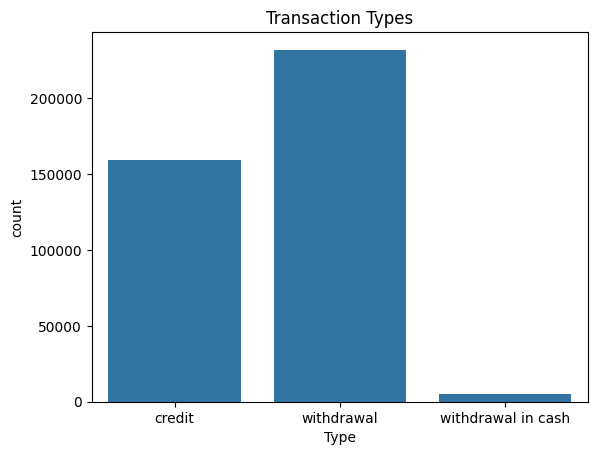

In [ ]:
sns.countplot(x="type", data=trans_dev)
plt.title("Transaction Types")
plt.xlabel("Type")
plt.show()

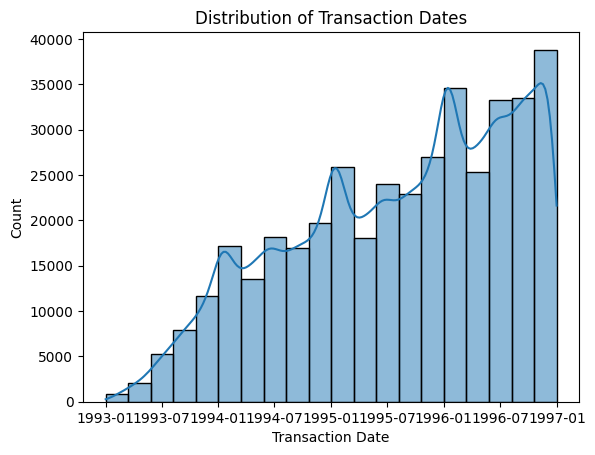

In [ ]:
trans_dev['date']=pd.to_datetime(trans_dev['date'], format='%y%m%d')
sns.histplot(trans_dev['date'], bins=20, kde=True)
plt.xlabel('Transaction Date')
plt.title('Distribution of Transaction Dates')
plt.show()

In [ ]:
trans_dev.describe()

,trans_id,account_id,date,amount,balance,account
count,3.966850e+05,396685.000000,396685.000000,396685.000000,396685.000000,1.022290e+05
mean,1.239338e+06,2508.434796,951310.066801,5677.552980,35804.792507,4.664229e+07
std,1.213288e+06,2020.928889,9510.974536,9190.364137,19692.148243,3.002136e+07
min,1.000000e+00,1.000000,930101.000000,0.000000,-13588.700000,0.000000e+00
25%,3.918330e+05,1092.000000,941110.000000,127.500000,22424.300000,1.990018e+07
50%,7.882580e+05,2220.000000,950930.000000,1952.000000,30959.600000,4.673618e+07
75%,1.273700e+06,3357.000000,960606.000000,6500.000000,44661.000000,7.232217e+07
max,3.682934e+06,11382.000000,961231.000000,86400.000000,193909.900000,9.998564e+07


#### Missing Values

In [ ]:
print(trans_dev.isna().sum())
print()
print("There are " + str(trans_dev.isna().sum().sum()) + " NA values")

trans_id           0
account_id         0
date               0
type               0
operation      70761
amount             0
balance            0
k_symbol      185244
bank          299443
account       294456
dtype: int64

There are 849904 NA values


#### Duplicate values

In [ ]:
print("Dataset length: " + str(len(trans_dev)))
print("Number of duplicates: " + str(trans_dev.duplicated().sum()))

Dataset length: 396685
Number of duplicates: 0


#### Merge Account, Disposition, Client and Loan datasets

In [143]:
account_disp = pd.merge(account, disp, on='account_id', how='inner')
account_disp_client = pd.merge(client, account_disp, on='client_id', how='inner')
account_disp_client_loan = pd.merge(loan_dev, account_disp_client, on='account_id', how='inner')
account_disp_client_loan['district_id'] = (account_disp_client_loan['district_id_x'] + account_disp_client_loan['district_id_y']) / 2
account_disp_client_loan.drop('district_id_x', axis=1, inplace=True)
account_disp_client_loan.drop('district_id_y', axis=1, inplace=True)

account_disp_client_loan.head()


,loan_id,account_id,date_x,amount,duration,payments,status,client_id,sex,age,frequency,date_y,disp_id,type,district_id
0,5314,1787,930705,96396,12,8033,-1,2166,Female,50,weekly issuance,1993-03-22,2166,OWNER,30.0
1,5316,1801,930711,165960,36,4610,1,2181,Male,29,monthly issuance,1993-02-13,2181,OWNER,46.0
2,6863,9188,930728,127080,60,2118,1,11314,Male,61,monthly issuance,1993-02-08,11006,OWNER,45.0
3,5325,1843,930803,105804,36,2939,1,2235,Female,57,monthly issuance,1993-01-30,2235,OWNER,13.0
4,7240,11013,930906,274740,60,4579,1,13539,Male,19,weekly issuance,1993-02-14,13231,OWNER,32.0


In [144]:
loan_counts = account_disp_client_loan['client_id'].value_counts().reset_index()
loan_counts.columns = ['client_id', 'number_loans']
client = client.merge(loan_counts, on='client_id', how='left')
client['number_loans'].fillna(0, inplace=True)
client.describe()

,client_id,district_id,age,number_loans
count,5369.000000,5369.000000,5369.000000,5369.000000
mean,3359.011920,37.310114,43.801639,0.075061
std,2832.911984,25.043690,17.282283,0.263514
min,1.000000,1.000000,10.000000,0.000000
25%,1418.000000,14.000000,29.000000,0.000000
50%,2839.000000,38.000000,43.000000,0.000000
75%,4257.000000,60.000000,57.000000,0.000000
max,13998.000000,77.000000,86.000000,1.000000
